In [1]:
import os
from PIL import Image
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature.texture import greycoprops, greycomatrix
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
folder_dataset = 'NEU-CLS'
types = ['RS', 'Pa', 'Cr', 'PS', 'In', 'Sc']
props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
seed =804

Dataset from [NEU surface defect database](http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html) y based on paper [Texture Descriptors for Automatic Estimation of Workpiece Quality in Milling](https://link.springer.com/chapter/10.1007/978-3-030-29859-3_62)

## Preprocessing

In [3]:
files = [file for file in os.listdir(folder_dataset) if file.endswith('.bmp')]
len(files)

1800

In [4]:
def process(id):
    name_file = files[id].split('_')
    data = {'image': files[id], 'type':name_file[0]}
    #Load image
    image = Image.open(folder_dataset+'/'+files[id])
    image = np.array(image)
    #CLAHE
    clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(5,5))
    cl1 = clahe.apply(image)
    
    g = greycomatrix(cl1, [1], [0, np.pi/2])
    for prop in props:
        propperty = greycoprops(g, prop)
        data[prop+'_prop'] = propperty[0][0]
        data[prop+'_angle'] = propperty[0][1]
    return data
    
    
df = pd.DataFrame(columns=['image', 'type']+ [prop+'_prop' for prop in props] + [prop+'_angle' for prop in props])
for i in range(0,len(files)):
    data = process(i)
    df = df.append(data, ignore_index=True)

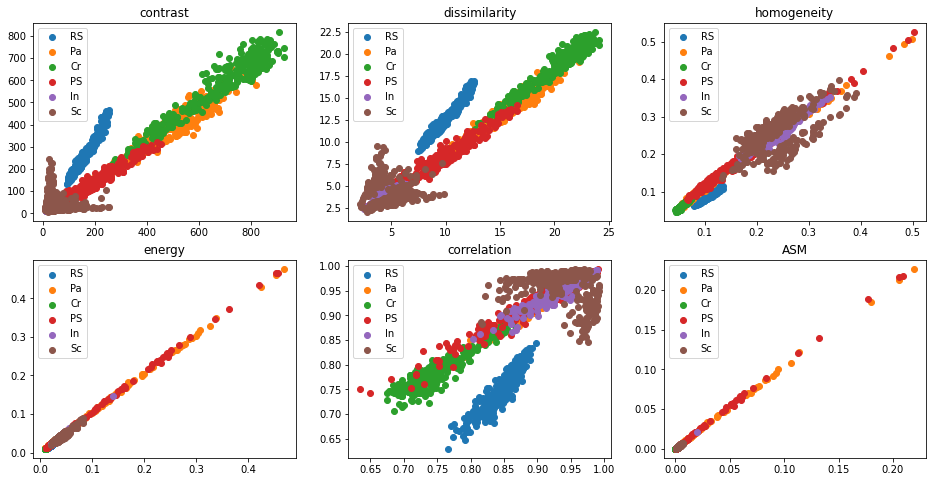

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for type_label in types:
    test = df[df.type==type_label]
    for i in range(0,len(props)):
        axs[int(i/3)][i%3].scatter(test.loc[:,props[i]+"_prop"], test.loc[:,props[i]+"_angle"], label=type_label)
        axs[int(i/3)][i%3].legend()
        axs[int(i/3)][i%3].title.set_text(props[i])
plt.show()

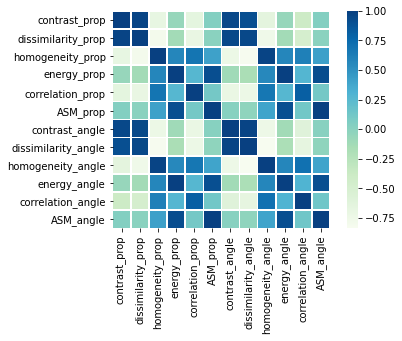

In [6]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, cmap='GnBu', linewidths=0.5, square=True)
plt.show()

## Prepare data

In [7]:
X_values = df[[prop+'_prop' for prop in props] + [prop+'_angle' for prop in props]]
y_values = df[['type']]
le = preprocessing.LabelEncoder()
le.fit(types)
y_values = le.transform(y_values.values.ravel())
"""
min_max_scaler = preprocessing.StandardScaler()
X_values_minmax = min_max_scaler.fit_transform(X_values)
"""
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values.ravel(), test_size=0.3, random_state=seed)

## GridSearch

In [8]:
models = [
            'ADB',
            'GBC',
            'RFC',
            'KNC',
            'SVC',
            'logisticRegression'
         ]
clfs = [
        AdaBoostClassifier(random_state=seed),
        GradientBoostingClassifier(random_state=seed),
        RandomForestClassifier(random_state=seed,n_jobs=-1),
        KNeighborsClassifier(n_jobs=-1),
        SVC(random_state=seed,probability=True),
        LogisticRegression(n_jobs=-1, random_state=seed)
        ]
params = {
            models[0]:{'n_estimators':range(100,200,50)},
            models[1]:{'n_estimators':range(10,150,10), 'max_depth':range(5,9)},
            models[2]:{'n_estimators':range(100,200,50), 'criterion':['gini', 'entropy']},
            models[3]:{'n_neighbors':[6], 'weights':['distance', 'uniform'],'leaf_size':range(5,30,5)},
            models[4]: {'C':range(1,15,5), 'kernel':['rbf', 'linear']},
            models[5]: {'multi_class':['multinomial'], 'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
         }

In [9]:
test_scores = []
y_estimation = 0
for name, estimator in zip(models,clfs):
    clf = GridSearchCV(estimator, params[name], scoring='accuracy', refit='True', n_jobs=-1, cv=5)
    clf.fit(X_train, y_train)
    test_scores.append((name, clf.best_params_, clf.best_score_))

In [10]:
results = pd.DataFrame(data=test_scores, columns=["name", "params", "acc_score"])
results = results.sort_values(by=['acc_score'], ascending=False,ignore_index=True)
results.head()

,name,params,acc_score
0,RFC,"{'criterion': 'entropy', 'n_estimators': 100}",0.930952
1,GBC,"{'max_depth': 5, 'n_estimators': 140}",0.927778
2,SVC,"{'C': 11, 'kernel': 'linear'}",0.913492
3,logisticRegression,"{'multi_class': 'multinomial', 'penalty': 'l2'...",0.887302
4,KNC,"{'leaf_size': 5, 'n_neighbors': 6, 'weights': ...",0.828571


In [11]:
print("Best classifier: "+results.loc[0,'name'])
print('params: '+str(results.loc[0,'params']))
print('Accuracy test: '+str(results.loc[0,'acc_score']))

Best classifier: RFC
params: {'criterion': 'entropy', 'n_estimators': 100}
Accuracy test: 0.9309523809523809


## Best classifier

In [15]:
model = RandomForestClassifier(random_state=seed,n_jobs=-1, criterion= 'entropy', n_estimators=100)
model = model.fit(X_train, y_train)
y_predict_train = model.predict(X_train)
print(classification_report(y_train,y_predict_train, target_names=types, digits=4))
y_predict = model.predict(X_test)
print(classification_report(y_test,y_predict, target_names=types, digits=4))

              precision    recall  f1-score   support

          RS     1.0000    1.0000    1.0000       209
          Pa     1.0000    1.0000    1.0000       206
          Cr     1.0000    1.0000    1.0000       209
          PS     1.0000    1.0000    1.0000       218
          In     1.0000    1.0000    1.0000       216
          Sc     1.0000    1.0000    1.0000       202

    accuracy                         1.0000      1260
   macro avg     1.0000    1.0000    1.0000      1260
weighted avg     1.0000    1.0000    1.0000      1260

              precision    recall  f1-score   support

          RS     0.9889    0.9780    0.9834        91
          Pa     0.8812    0.9468    0.9128        94
          Cr     0.8977    0.8681    0.8827        91
          PS     0.9091    0.9756    0.9412        82
          In     1.0000    1.0000    1.0000        84
          Sc     0.9438    0.8571    0.8984        98

    accuracy                         0.9352       540
   macro avg     0.9368

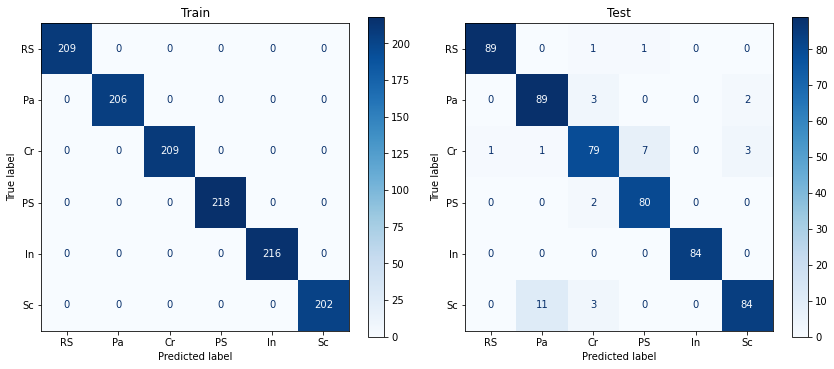

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_confusion_matrix(model,X_train, y_train,ax=axes[0], cmap='Blues',display_labels=types)
axes[0].title.set_text('Train')
plot_confusion_matrix(model,X_test, y_test,ax=axes[1], cmap='Blues',display_labels=types)
axes[1].title.set_text('Test')
plt.tight_layout()
plt.show()